(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from datetime import datetime

In [5]:
# import multichannel ecg data by R.Moss
data = pd.read_csv('./ECG_data/moss/MeasuredECG.txt', sep=" ", header=1)
data.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

<IPython.core.display.Javascript object>


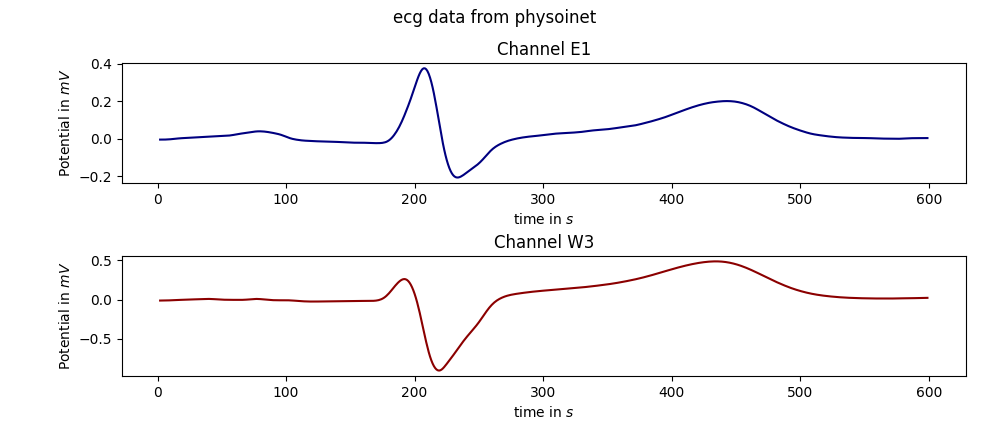

In [408]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.suptitle('ecg data from physoinet')
plt.title('Channel E1')
plt.plot(data['time'], data['E1'], label='Channel E1', c='navy')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(2, 1, 2)
plt.title('Channel W3')
plt.plot(data['time'], data['W3'], label='Channel W3', c='darkred')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.tight_layout()
plt.show()

In [409]:
# original time series
z_1 = np.array(data['E1'])
z_2 = np.array(data['W3'])
'''print('validation before cut:', z_1[0] == z_1[-1])
print('validation before cut:', z_2[0] == z_2[-1])

# these are the points where the periodical condition is true
# we cut at the last possible point
o_1 = np.where(z_1 == z_1[0])
o_2 = np.where(z_2 == z_2[0])
z_1_cut = z_1[0:o_1[0][-1] + 1]
z_2_cut = z_2[0:o_2[0][-1] + 1]

# validating cut
print('validation after cut:', z_1_cut[0] == z_1_cut[0])
print('validation after cut:', z_2_cut[0] == z_2_cut[0])'''
pass

In [410]:
z_1_derivate = five_point_derivate_periodic(z_1)
z_2_derivate = five_point_derivate_periodic(z_2)
z_1_min = min(z_1)
z_1_max = max(z_1)
z_2_min = min(z_2)
z_2_max = max(z_2)

# fit to a 2d ode system
With the time series $y_{E1}$ and $y_{E2}$ a fit can be done to a system:

$$
y_1 = y_{E1} = f_1(y_1, y_2; \vec{p}) = p_0y_1+p_1y_2+p_2y_1^2+p_3y_1y_2+p_4y_2^2+...+y_2^3
\\
y_2 = y_{E2} = f_2(y_y, y_2; \vec{q})
$$

In [411]:
def compute_2d_polynominal(grade):
    y_res = []
    ydot_res = []
    
    while grade > 0:
        o = compute_2d_polynominal_single_part(grade)
        y_res += o[0]
        ydot_res += o[1]
        
        grade -= 1

    return (y_res[::-1], ydot_res[::-1])

def compute_2d_polynominal_single_part(grade):
    y = [0, 1] # needs to be reversed at end
    ydot = [1, 0] # same
    
    if grade == 0:
        return ([], [])
    grade -= 1
    
    while grade > 0:
        grade -= 1
        y.append(y[-1] + 1)
        
        ydot = [el + 1 for el in ydot]
        ydot.append(0)
        
    return (y, ydot)

In [412]:
def fit_coefficients_2d_variable(y_1, y_2, z, grade=3):
    polynominal = compute_2d_polynominal(grade)
    #rhs_without_measured = polynominal
    
    len_polynominal = len(polynominal[0])
    
    a = np.ones((len_polynominal, len_polynominal))
    for i in range(len_polynominal):
        for j in range(len_polynominal):
            a[i][j] *= np.sum(y_1 ** (polynominal[0][j] + polynominal[0][i]) * \
                              y_2 ** (polynominal[1][j] + polynominal[1][i]))
            #if (i == 4 and j == 4) or (i == 8 and j == 4) or (i == 4 and j == 8):
            #    print(polynominal[0][j], polynominal[0][i])
            #    print(polynominal[1][j], polynominal[1][i])
    
    b = np.ones((len_polynominal, 1))
    for i in range(len_polynominal):
        b[i] *= np.sum(z * y_1 ** polynominal[0][i] * y_2 ** polynominal[1][i])
        
    #print(a)
    #print(b)
    
    return np.linalg.solve(a, b)

In [413]:
def fit_coefficients_2d(y_1, y_2, z, _):
    #return
    print('function "fit_coefficients_2d" is deprecated and will be removed soon')
    
    a = [
         [np.sum(y_1 ** 2), np.sum(y_1 * y_2), np.sum(y_1 ** 3), np.sum(y_1 ** 2 * y_2), np.sum(y_1 * y_2 ** 2)],
         [np.sum(y_1 * y_2), np.sum(y_2 ** 2), np.sum(y_1 ** 2 * y_2), np.sum(y_1 * y_2 ** 2), np.sum(y_2 ** 3)],
         [np.sum(y_1 ** 3), np.sum(y_1 ** 2 * y_2), np.sum(y_1 ** 4), np.sum(y_1 ** 3 * y_2), np.sum(y_1 ** 2 * y_2 ** 2)],
         [np.sum(y_1 ** 2 * y_2), np.sum(y_1 * y_2 ** 2), np.sum(y_1 ** 3 * y_2), np.sum(y_1 ** 2 * y_2 ** 3), \
          np.sum(y_1 * y_2 ** 3)],
         [np.sum(y_1 ** 2 * y_2 ** 2), np.sum(y_2 ** 3), np.sum(y_1 ** 2 * y_2 ** 2), np.sum(y_1 * y_2 ** 3), \
          np.sum(y_2 ** 4)],
        ]
    b = [
         [np.sum(z * y_1)],
         [np.sum(z * y_2)],
         [np.sum(z * y_1 ** 2)],
         [np.sum(z * y_1 * y_2)],
         [np.sum(z * y_2 ** 2)],
        ]
    
    return np.linalg.solve(a, b)

In [414]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]

    return derivate

In [415]:
def convert_coeffictents_to_fit_function(p):
    #return
    print('function "convert_coeffictents_to_fit_function" is deprecated and will be removed soon')
    def func(y_1, y_2):
        res = p[0] * y_1 + p[1] * y_2 + p[2] * y_1 ** 2 + p[3] * y_1 * y_2 + p[4] * y_2 ** 2
        return res
    return func

In [416]:
def convert_fit_coefficients_to_function(p):   
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')
    
    len_polyn = len(p)
    grade = 0
    while len_polyn > 0:
        grade += 1
        len_polyn -= grade + 1

    print('Polynominal of grade %i detected' % (grade))

    y_1_poly, y_2_poly = compute_2d_polynominal(grade)

    def func(y_1, y_2):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_1 ** y_1_poly[i] * y_2 ** y_2_poly[i]
        return res

    return func

In [676]:
p = fit_coefficients_2d_variable(z_1, z_2, five_point_derivate_periodic(z_1), 8)
q = fit_coefficients_2d_variable(z_1, z_2, five_point_derivate_periodic(z_2), 8)

In [677]:
p_ = convert_fit_coefficients_to_function(p)
q_ = convert_fit_coefficients_to_function(q)

Polynominal of grade 8 detected
Polynominal of grade 8 detected


<IPython.core.display.Javascript object>


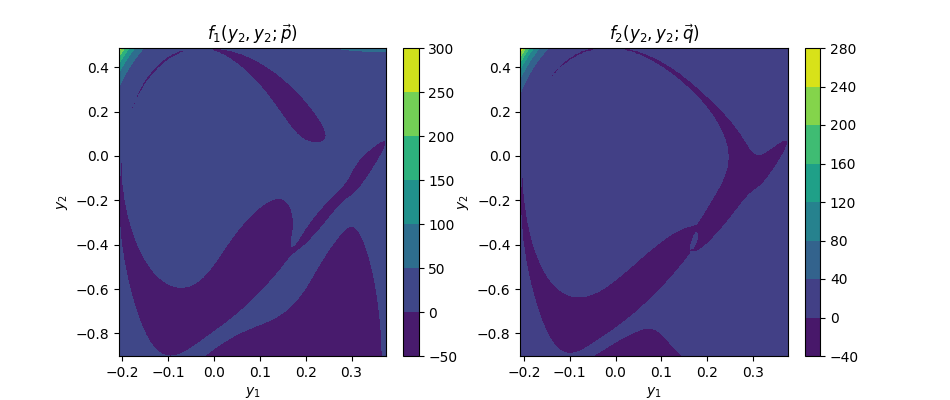

In [678]:
%matplotlib notebook

x = np.linspace(z_1_min, z_1_max, 100)
y = np.linspace(z_2_min, z_2_max, 100)

fig = plt.figure(figsize=(9.5, 4))
#fig.suptitle('')

ax_1 = fig.add_subplot(1, 2, 1)
r_1 = [[np.sum(p_(el, sel)) for sel in y] for el in x]
c = ax_1.contourf(x, y, r_1)
fig.colorbar(c)
ax_1.set_xlabel('$y_1$')
ax_1.set_ylabel('$y_2$')
ax_1.set_title('$f_1(y_2,y_2;\\vec{p})$')

ax_2 = fig.add_subplot(1, 2, 2)
r_2 = [[np.sum(q_(el, sel)) for sel in y] for el in x]
c = ax_2.contourf(x, y, r_2)
fig.colorbar(c)
ax_2.set_xlabel('$y_1$')
ax_2.set_ylabel('$y_2$')
ax_2.set_title('$f_2(y_2,y_2;\\vec{q})$')

plt.show()

In [679]:
def func(t, x, fit_to_y_1, fit_to_y_2):
    '''
    '''
    #assert(abs(x[1]) <= 10e10)
    y = [0, 0]
    
    y[0] = fit_to_y_1(x[0], x[1])[0]
    y[1] = fit_to_y_2(x[0], x[1])[0]
    return y

In [683]:
T = len(z_1)*4

ivp = [0, 0]
index_start = 219
ivp[0] += z_1[index_start]
ivp[1] += z_2[index_start]

sol = solve_ivp(func, [0, T], [ivp[0], ivp[1]], dense_output=True, args=[p_, q_])

In [684]:
f = 8
t = np.linspace(0, T, T*f)
y_1, y_2 = sol.sol(t)

res = (t, y_1, y_2)

<IPython.core.display.Javascript object>


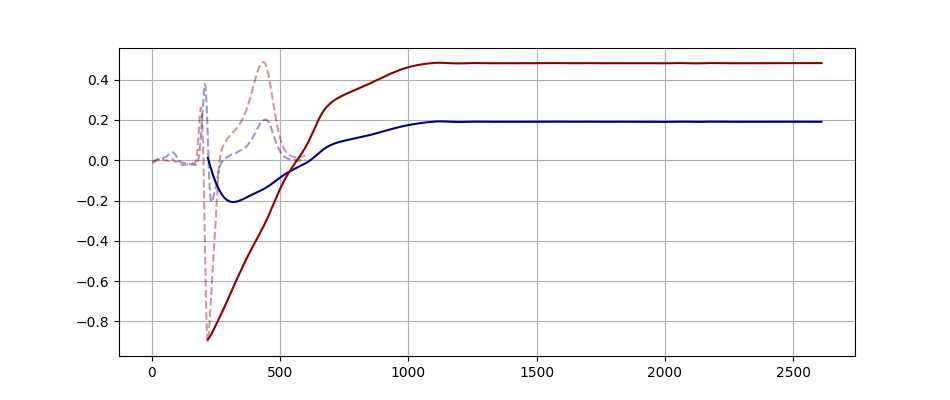

In [685]:
%matplotlib notebook
mi = T

fig = plt.figure(figsize=(9.5, 4))

ax = fig.add_subplot(1, 1, 1)
ax.plot(f * res[0][:mi]+index_start, res[1][:mi], color='navy')
ax.plot(data['time'], 1*z_1, linestyle='--', color='navy', alpha=.4)
ax.plot(f * res[0][:mi]+index_start, res[2][:mi], color='darkred')
ax.plot(data['time'], 1*z_2, linestyle='--', color='darkred', alpha=.4)
ax.plot()
ax.grid()

fig.show()